# Лабораторная работа 2

выполнил студент группы М8О-201Б-20

Зайцев Кирилл Владимирович

Для начала подключим все необходимые библиотеки python и загрузим данные, как в семинаре 4.4

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets, models
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable
from collections import namedtuple
from IPython.display import Image

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])
import torchvision
import torchvision.transforms as transforms
%matplotlib inline
np.random.seed(2018)

from torchvision.datasets import FashionMNIST

activation =  {'ELU': torch.nn.ELU(), 'Hardtanh': torch.nn.Hardtanh(),
               'LeakyReLU': torch.nn.LeakyReLU(), 'LogSigmoid': torch.nn.LogSigmoid(),
               'PReLU': torch.nn.PReLU(), 'ReLU': torch.nn.ReLU(), 'ReLU6': torch.nn.ReLU6(),
               'RReLU': torch.nn.RReLU(), 'SELU': torch.nn.SELU(), 'CELU': torch.nn.CELU(),
               'Sigmoid': torch.nn.Sigmoid(), 'Softplus': torch.nn.Softplus(),
               'Softshrink': torch.nn.Softshrink(), 'Softsign': torch.nn.Softsign(),
               'Tanh': torch.nn.Tanh(), 'Tanhshrink': torch.nn.Tanhshrink(),
               'Hardshrink': torch.nn.Hardshrink()}


C:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\Anaconda\lib\site-packages\torchvision\datasets\mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])
torch.Size([28, 28])


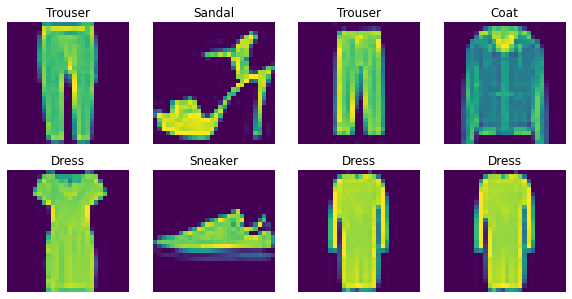

In [2]:
# Fashion Class that enables the Dataset download and basic transformations
class Fashion(torchvision.datasets.FashionMNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        self.urls = [
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz',
            'http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz',
        ]
        super(torchvision.datasets.FashionMNIST, self).__init__(
            root, train=train, transform=transform, target_transform=target_transform, download=download
        ) 

def decode_label(l):
    return ["Top",
     "Trouser",
     "Pullover",
     "Dress",
     "Coat",
     "Sandal",
     "Shirt",
     "Sneaker",
     "Bag",
     "Ankle boot"
    ][l]

transform=transforms.Compose([transforms.ToTensor(), \
                              transforms.Normalize((0.1307,), (0.3081,))])
train_data = FashionMNIST('./data',
    download=True,
    train=True,
    transform=transform)

test_data = torchvision.datasets.FashionMNIST('./data',
    download=True,
    train=False,
    transform=transform)


x_train = train_data.train_data
y_train = train_data.train_labels
x_validation = test_data.test_data
y_validation = test_data.test_labels

x_validation = x_validation.unsqueeze(1).float()
x_train = x_train.unsqueeze(1).float()

idxs = np.random.randint(100, size=8)
f, a = plt.subplots(2, 4, figsize=(10, 5))
for i in range(8):
    X = train_data.train_data[idxs[i]]
    Y = train_data.train_labels[idxs[i]]
    r, c = i // 4, i % 4
    a[r][c].set_title(decode_label(Y))
    a[r][c].axis('off')
    a[r][c].imshow(X.numpy())
    print(X.shape)
plt.draw();

Создадим класс сети LeNet5, в конструкторе которого будет указываться функция активации

In [3]:
class LeNet5(torch.nn.Module):
    def __init__(self, activ):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = activ
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = activ
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = activ
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = activ
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x

In [4]:
def training(net, optimizer, batch_size, x_train, y_train, x_validation, y_validation):
    loss = torch.nn.CrossEntropyLoss()
    train_accuracy = []
    validation_accuracy  = []
    validation_loss = []
    train_loss = []
    xlen = len(x_train)
    for epoch in range(40):
        order =  np.random.permutation(xlen)
        for start_index in range(0, xlen, batch_size):
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index+batch_size]
            x_batch = x_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = net.forward(x_batch)
            
            if (start_index % 100000 == 0):
                train_loss.append(loss(preds, y_batch))    
                train_acc = (preds.argmax(dim=1) == y_batch).float().mean()
                train_accuracy.append(train_acc)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()

        test_preds = net.forward(x_validation)
        validation_loss.append(loss(test_preds, y_validation).data.cpu())    
        test_accuracy = (test_preds.argmax(dim=1) == y_validation).float().mean().data.cpu()
        validation_accuracy.append(test_accuracy)
        
    return train_accuracy, validation_accuracy

## Тестирование разных функций активации

$Tanh$

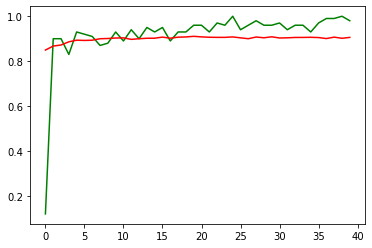

In [5]:
testnet = LeNet5(activation.get('Tanh'))
Tanh_train, Tanh_test = training(testnet, torch.optim.Adam(testnet.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)
plt.plot(Tanh_train, 'g', label = "test")
plt.plot(Tanh_test, 'r', label = "train")
plt.show()

$Elu$

In [6]:
testnet2 = LeNet5(activation.get('ELU'))
Elu_train, Elu_test = training(testnet2, torch.optim.Adam(testnet2.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)


$Hardtanh$

In [7]:
testnet3 = LeNet5(activation.get('Hardtanh'))
Hardtanh_train, Hardtanh_test = training(testnet3, torch.optim.Adam(testnet3.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)


$LogSigmoid$

In [8]:
testnet4 = LeNet5(activation.get('LogSigmoid'))
LogSigmoid_train, LogSigmoid_test = training(testnet4, torch.optim.Adam(testnet4.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)

$ReLU$

In [9]:
testnet5 = LeNet5(activation.get('ReLU'))
ReLU_train, ReLU_test = training(testnet5, torch.optim.Adam(testnet5.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)

$Sigmoid$

In [10]:
testnet6 = LeNet5(activation.get('Sigmoid'))
Sigmoid_train, Sigmoid_test = training(testnet6, torch.optim.Adam(testnet6.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)

График сравнения различных функций

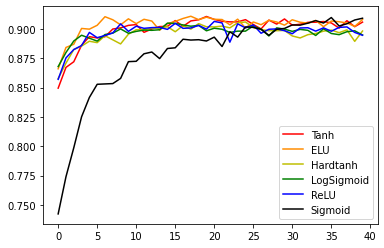

In [11]:
plt.plot(Tanh_test, 'r', label = "Tanh")
plt.plot(Elu_test, 'darkorange', label = "ELU")
plt.plot(Hardtanh_test, 'y', label = "Hardtanh")
plt.plot(LogSigmoid_test, 'g', label = "LogSigmoid")
plt.plot(ReLU_test, 'b', label = "ReLU")
plt.plot(Sigmoid_test, 'k', label = "Sigmoid")
plt.legend()

Как видно, лучшая точность получилась у функции активации $Sigmoid$

## Тестирование различных оптимизаторов

Для функции $Adam$ тест уже проведён. Теперь исследуем алгоритмы $RMSProp$, $Ada$, $SGD$, $Momentum$

$RMSProp$

In [12]:
testmod1 = LeNet5(activation.get('Tanh'))
RMSProp_train, RMSProp_test = training(testmod1, torch.optim.RMSprop(testmod1.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)

$Ada$

In [13]:
testmod2 = LeNet5(activation.get('Tanh'))
Ada_train, Ada_test = training(testmod2, torch.optim.Adagrad(testmod2.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)

$SGD$

In [14]:
testmod3 = LeNet5(activation.get('Tanh'))
SGD_train, SGD_test = training(testmod3, torch.optim.SGD(testmod3.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)

$Nesterov$

In [15]:
testmod4 = LeNet5(activation.get('Tanh'))
Nesterov_train, Nesterov_test = training(testmod4, torch.optim.SGD(testmod4.parameters(), lr=1.0e-3, momentum = 0.9, nesterov = True), 100, x_train, y_train, x_validation, y_validation)

$Momentum$

In [16]:
testmod5 = LeNet5(activation.get('Tanh'))
Momentum_train, Momentum_test = training(testmod5, torch.optim.SGD(testmod5.parameters(), lr=1.0e-3, momentum = 0.9), 100, x_train, y_train, x_validation, y_validation)

График сравнения оптимизаторов

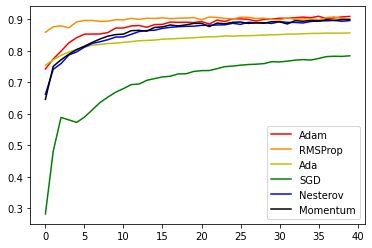

In [17]:
plt.plot(Sigmoid_test, 'r', label = "Adam")
plt.plot(RMSProp_test, 'darkorange', label = "RMSProp")
plt.plot(Ada_test, 'y', label = "Ada")
plt.plot(SGD_test, 'g', label = "SGD")
plt.plot(Nesterov_test, 'b', label = "Nesterov")
plt.plot(Momentum_test, 'k', label = "Momentum")
plt.legend()

## Тестирование различных размером батча

батч 10

In [18]:
batch10_net = LeNet5(activation.get('Sigmoid'))
batch10_train, batch10_test = training(batch10_net, torch.optim.Adam(batch10_net.parameters(), lr=1.0e-3), 10, x_train, y_train, x_validation, y_validation)

батч 100 рассмотрен в тестах выше

батч 500

In [19]:
batch500_net = LeNet5(activation.get('Sigmoid'))
batch500_train, batch500_test = training(batch500_net, torch.optim.Adam(batch500_net.parameters(), lr=1.0e-3), 500, x_train, y_train, x_validation, y_validation)

График сравнения батчей

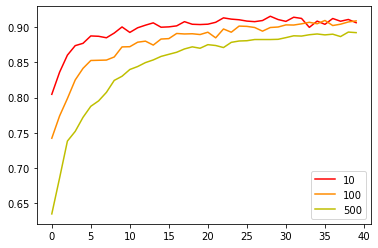

In [20]:
plt.plot(batch10_test, 'r', label = "10")
plt.plot(Sigmoid_test, 'darkorange', label = "100")
plt.plot(batch500_test, 'y', label = "500")
plt.legend()

In [21]:
def init_xavier(m):
    if type(m) == nn.Linear:
        fan_in = m.weight.size()[1]
        fan_out = m.weight.size()[0]
        std = np.sqrt(2.0 / (fan_in + fan_out))
        m.weight.data.normal_(0,std)

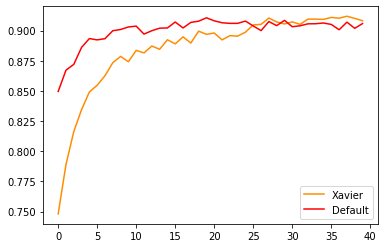

In [22]:
xavier = LeNet5(activation.get('Sigmoid'))
xavier.apply(init_xavier)
xavtrain, xavtest = training(xavier, torch.optim.Adam(xavier.parameters(), lr=1.0e-3), 100, x_train, y_train, x_validation, y_validation)

plt.plot(xavtest, 'darkorange', label = "Xavier")
plt.plot(Tanh_test, 'r', label = "Default")
plt.legend()

# Вывод

Наилучшей функцией активации оказалась сигмоида, оптимизатор --- Адам, сравнимы с ним по точности RMSProp и Nesterov, а оптимальным оказался размер батча от 50 до 100. Также я добавил инициализацию Ксавьера, которая улучшила точность работы сети.